# Purpose

This notebook demonstrates the model experimentation and finalization. It covers EDA, outlier treatment, transformation, training, model evaluation and comparison across models.

## Imports

In [186]:
import os
import os.path as op
import shutil

# standard third party imports
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.feature_selection import SelectFromModel
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.compose import ColumnTransformer

# impute missing values
from sklearn.experimental import enable_iterative_imputer  # noqa
from sklearn.impute import KNNImputer, IterativeImputer, SimpleImputer
from sklearn.tree import DecisionTreeRegressor
from category_encoders import TargetEncoder


In [187]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [188]:
import warnings

warnings.filterwarnings('ignore', message="pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.", 
                        category=FutureWarning)
warnings.filterwarnings('ignore', message="pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.",
                        category=FutureWarning)

In [189]:
# standard code-template imports
from ta_lib.core.api import (
    create_context, get_dataframe, get_feature_names_from_column_transformer, string_cleaning,
    get_package_path, display_as_tabs, save_pipeline, load_pipeline, initialize_environment,
    load_dataset, save_dataset, DEFAULT_ARTIFACTS_PATH
)

import ta_lib.eda.api as eda
from xgboost import XGBRegressor
from ta_lib.regression.api import SKLStatsmodelOLS
from ta_lib.regression.api import RegressionComparison, RegressionReport
import ta_lib.reports.api as reports
from ta_lib.data_processing.api import Outlier

initialize_environment(debug=False, hide_warnings=True)

# Initialization

In [190]:
artifacts_folder = DEFAULT_ARTIFACTS_PATH
print(artifacts_folder)

/mnt/c/users/sai.javvaji/desktop/regression_codetemp/regression-py/src/../artifacts


In [191]:
config_path = op.join('conf', 'config.yml')
context = create_context(config_path)

# 3 Feature Engineering

The focus here is the `Pipeline` and not the model. Though the model would inform the pipeline that is needed to train the model, our focus is to set it up in such a way that it can be saved/loaded, tweaked for different model choices and so on.

## 3.1 Read the Train and Test Data

In [192]:
train_X = load_dataset(context, 'train/housing/features')
train_y = load_dataset(context, 'train/housing/target')
print(train_X.shape, train_y.shape)

test_X = load_dataset(context, 'test/housing/features')
test_y = load_dataset(context, 'test/housing/target')
print(test_X.shape, test_y.shape)

(16512, 9) (16512, 1)
(4128, 9) (4128, 1)


## 3.2 Feature Engineering Pipelines


**Dev NOTES**

For Feature Engineering and Model Building sklearn.pipeline.Pipeline are leveraged because of the following advantages
<details>
    
1. It helps in automating workflows and are easier to read and comprehend.
2. Right Sequence can be ensured and (for example always encodes before imputing)
3. Reproducibility is very convenient with pipelines
4. Pipelines help you prevent data leakage in your test data
5. Code is near implementation ready

#### General Steps in the Feature Transformation are as follows
 - Outlier Treatment
 - Encoding of Categorical Columns
 - Missing Values Imputation

In [193]:
# collecting different types of columns for transformations
cat_columns = train_X.select_dtypes('object').columns
num_columns = train_X.select_dtypes('number').columns

#### Outlier Handling
- A Custom Transformer is used to handle outliers. It is not included as part of the pipeline as outliers handling are optional for test data
- An option to either drop or cap the outliers can be passed during the transform call
- If we want to treat outliers for some columns them we can pass cols argument to the Transformer
- This will go into production code

In [194]:
from sklearn.base import BaseEstimator, TransformerMixin

class CombinedAttributesAdder(BaseEstimator, TransformerMixin):
    def __init__(self, add_bedrooms_per_room=True):  # no *args or **kargs
        self.add_bedrooms_per_room = add_bedrooms_per_room

    def fit(self, X, y=None):
        return self  # nothing else to do

    def transform(self, X):
        rooms_per_household = X[:, rooms_ix] / X[:, households_ix]
        population_per_household = X[:, population_ix] / X[:, households_ix]
        if self.add_bedrooms_per_room:
            bedrooms_per_room = X[:, bedrooms_ix] / X[:, rooms_ix]
            return np.c_[
                X,
                rooms_per_household,
                population_per_household,
                bedrooms_per_room,
            ]

        else:
            return np.c_[X, rooms_per_household, population_per_household]

In [195]:
outlier_transformer = Outlier(method='mean')
print(train_X.shape)
train_X = outlier_transformer.fit_transform(train_X)
print(train_X.shape)

(16512, 9)
(16512, 9)


In [196]:
imputer = SimpleImputer(strategy="median")

In [197]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler

stnd_scaler = StandardScaler()

In [198]:
cat_encoder = OneHotEncoder()

In [199]:
attr_adder = CombinedAttributesAdder(add_bedrooms_per_room = True)

In [200]:
num_pipeline = Pipeline(
    [
        ("imputer", imputer),
        ("attribs_adder", attr_adder),
        ("std_scaler", stnd_scaler),
    ]
)

features_transformer = ColumnTransformer(
    [
        ("num", num_pipeline, num_columns),
        ("cat", cat_encoder, cat_columns),
    ]
)


#### Encoding


Some sample pipelines showcasing how to create column specific pipelines and integrating them overall is presented below

- Commonly target encoding is done for categorical variables with too many levels.
- We also group sparse levels. For fewer levels one hot encoding/label encoding is preferred.
- If there is one dominant level, we can use binary encoding.
- This will go into production code

In [201]:
# tgt_enc_simple_impt = Pipeline([
#     ('target_encoding', TargetEncoder(return_df=False)),
#     ('simple_impute', SimpleImputer(strategy='most_frequent')),
# ])


# # NOTE: the list of transformations here are not sequential but weighted 
# # (if multiple transforms are specified for a particular column)
# # for sequential transforms use a pipeline as shown above.
# features_transformer = ColumnTransformer([
    
#     ## categorical columns
#     ('tgt_enc', TargetEncoder(return_df=False),
#      list(set(cat_columns) - set(['technology', 'functional_status', 'platforms']))),
    
#     # NOTE: if the same column gets repeated, then they are weighed in the final output
#     # If we want a sequence of operations, then we use a pipeline but that doesen't YET support
#     # get_feature_names. 
#     ('tgt_enc_sim_impt', tgt_enc_simple_impt, ['technology', 'functional_status', 'platforms']),
        
#     ## numeric columns
#     ('med_enc', SimpleImputer(strategy='median'), num_columns),
    
# ])


**Dev notes(Encoding):**
<details>

    Some common practices followed in Categorical Feature Encoding are
    * For categorical variables with too many levels, target encoding can be done.
    * For fewer levels, one hot encoding can be done.
    * If one very dominant level is observed, binary encoding can be used.
    
    
</details>

## 3.2 Feature analysis

Using the pipeline above analyze the features and decide on additional features to add/remove from the pipeline. This section will not be part of the production code, unless input data drifts etc. are explicitly demanded in the project.

Here we are primarily focused on feature selection/elimination based on business rules, prior knowledge, data analysis.

**We are not building any models at this point.**


- we create some sample data to analyze that we assume represent the population
- train the features transformer and do the analysis as below

In [202]:
rooms_ix, bedrooms_ix, population_ix, households_ix = 3, 4, 5, 6

In [203]:
sample_X = train_X.sample(frac=0.1, random_state=context.random_seed)
sample_y = train_y.loc[sample_X.index]

sample_train_X = get_dataframe(
    features_transformer.fit_transform(sample_X, sample_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

# nothing to do for target
sample_train_y = sample_y

Running the features transformer on the complete data

In [204]:
train_X.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,ocean_proximity
0,-118.04,33.99,47.0,2530.0,565.0,1262.0,509.0,3.6475,1H OCEAN
1,-122.20,37.82,37.0,1229.0,181.0,420.0,176.0,7.0175,NEAR BAY
2,-118.25,34.09,52.0,3142.0,765.0,1728.0,682.0,3.1864,1H OCEAN
3,-117.99,33.70,25.0,2017.0,357.0,1063.0,369.0,4.0345,1H OCEAN
4,-120.88,37.52,2.0,1871.0,409.0,707.0,256.0,2.6103,INLAND


In [205]:
sample_train_X.head()

,num_x0,num_x1,num_x2,num_x3,num_x4,num_x5,num_x6,num_x7,num_x8,num_x9,num_x10,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,ocean_proximity_NEAR BAY,ocean_proximity_NEAR OCEAN
0,0.175809,0.267753,-1.022622,0.141599,-0.025416,0.261785,0.112135,-0.043140,-0.024011,0.231115,-0.438588,0.0,1.0,0.0,0.0
1,-1.312558,0.937522,1.814410,-0.491983,-0.121471,-0.585811,-0.096872,-0.630365,-0.846261,-1.261343,0.952592,0.0,0.0,1.0,0.0
2,1.151461,-0.725351,-1.810686,1.779600,2.224593,1.716220,2.135705,-0.102610,-0.277947,-0.448829,0.190729,0.0,1.0,0.0,0.0
3,1.280885,-0.402015,-1.180235,0.449767,0.280213,0.411296,0.219805,-0.124012,0.294904,0.297433,-0.408950,0.0,1.0,0.0,0.0
4,0.096164,0.341659,-0.155751,-0.586273,-0.313580,0.354130,-0.293213,-1.508549,-0.759690,1.695479,0.771074,0.0,1.0,0.0,0.0


In [206]:
list(sample_train_X.columns)[11:]

['ocean_proximity_1H OCEAN',
 'ocean_proximity_INLAND',
 'ocean_proximity_NEAR BAY',
 'ocean_proximity_NEAR OCEAN']

In [207]:
col_list = list(train_X.columns) + ['rooms_per_household', 'population_per_household', 'bedrooms_per_room']

In [208]:
train_X.isnull().sum()

longitude               0
latitude                0
housing_median_age      0
total_rooms             0
total_bedrooms        158
population              0
households              0
median_income           0
ocean_proximity         0
dtype: int64

In [209]:
train_X = get_dataframe(
    features_transformer.fit_transform(train_X, train_y), 
    get_feature_names_from_column_transformer(features_transformer)
)

In [210]:
train_X.isnull().sum()

num_x0                        0
num_x1                        0
num_x2                        0
num_x3                        0
num_x4                        0
num_x5                        0
num_x6                        0
num_x7                        0
num_x8                        0
num_x9                        0
num_x10                       0
ocean_proximity_1H OCEAN      0
ocean_proximity_INLAND        0
ocean_proximity_ISLAND        0
ocean_proximity_NEAR BAY      0
ocean_proximity_NEAR OCEAN    0
dtype: int64

### 3.2.1 Univariate


- Look at each variable independently. This is useful if your models have assumptions on the distribution and/or bounds on the features/target

In [211]:
out = eda.get_density_plots(train_X, cols=list(train_X.columns)[:11])
out

:DynamicMap   [col]
   :Layout
      .Overlay.I :Overlay
         .Histogram.I    :Histogram   [x]   (Frequency)
         .Distribution.I :Distribution   [num_x0]   (Density)
      .Table.I   :Table   [count,mean,std,min,25%,50%,75%,max]

In [212]:
# save the plots are html
reports.create_report({'univariate': out}, name='feature_analysis_univariate')

A report containing the above plot is available [here](https://drive.google.com/file/d/16ntqUc_zvpg0at5pTtO-ljBjw5UVGFnp/view?usp=sharing)


Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1vUaCcs1PJ4IYo1em9-eZIEj9WuDsnFKT/view?usp=sharing)

In [213]:
reports.feature_analysis(train_X,'./feature_analysis_report.html')

p-value may not be accurate for N > 5000.


### 3.2.2 Bivariate - mutual interactions

- Find columns with high correlations and drop them

In [214]:
out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,num_x4,num_x6,0.972044,0.972044
1,num_x0,num_x1,-0.925628,0.925628
2,num_x3,num_x4,0.920203,0.920203
3,num_x3,num_x6,0.912943,0.912943
4,num_x5,num_x6,0.908202,0.908202
5,num_x4,num_x5,0.872036,0.872036
6,num_x3,num_x5,0.841843,0.841843
7,ocean_proximity_1H OCEAN,ocean_proximity_INLAND,-0.608116,0.608116


In [215]:
# channel and source_channel highly correlated. So discarding source_channel
# brand and manufacturer are almost same so discarding manufacturer.
# Similarly keeping sku between inventory and sku
# Similarly keeping condition between conditions and ext_grade
# Similarly keeping model_family between platforms, ext_model_family and model_family
# Discarding selling price & selling cost as they are multiples of unit price/cost & quantity.
# Discarding gp as it is the of selling price and selling cost
# order_no, line, invoice_no & customername cannot be IDVs
curated_columns = list(
    set(train_X.columns.to_list()) 
    - set(['ocean_proximity_INLAND', 'num_x6', 'num_x3'])
)

train_X = train_X[curated_columns]

out = eda.get_correlation_table(train_X)
out[out["Abs Corr Coef"] > 0.6]

,Variable 1,Variable 2,Corr Coef,Abs Corr Coef
0,num_x0,num_x1,-0.925628,0.925628
1,num_x4,num_x5,0.872036,0.872036


In [153]:
# out = eda.get_bivariate_plots(train_X, x_cols=['brand'], y_cols=['color'])
# out

In [216]:
%%time
# create reports as needed
cols = train_X.columns.to_list()
all_plots = {}
for ii, col1 in enumerate(cols): 
    for jj in range(ii+1, len(cols)):
        col2 = cols[jj]
        out = eda.get_bivariate_plots(train_X, x_cols=[col1], y_cols=[col2])
        all_plots.update({f'{col2} vs {col1}': out})

reports.create_report(all_plots, name='feature_analysis_bivariate')

CPU times: user 20.2 s, sys: 19.6 s, total: 39.8 s
Wall time: 15.6 s


A report containing the bivariate plot is available [here](https://drive.google.com/file/d/1WSGT3586tY-rOmZ57xGILbmL5ll9cSVT/view?usp=sharing)

Alternatively, the above plots can be generated as a single html as below. The output from this is available [here](https://drive.google.com/file/d/1A2fz_bjYv8I3iaFDT75JQSDKeJEXxCtp/view?usp=sharing)

In [217]:
reports.feature_interactions(train_X,'./feature_interaction_report.html')

### 3.2.3 Key Drivers - Interaction with Target variable

In [218]:
out = eda.get_target_correlation(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Tabs
    [0] HoloViews(Bars, name='feature_correlation')

Tabs
    [0] HoloViews(Bars, name='from_model')
    [1] Matplotlib(Figure, name='shap_values')
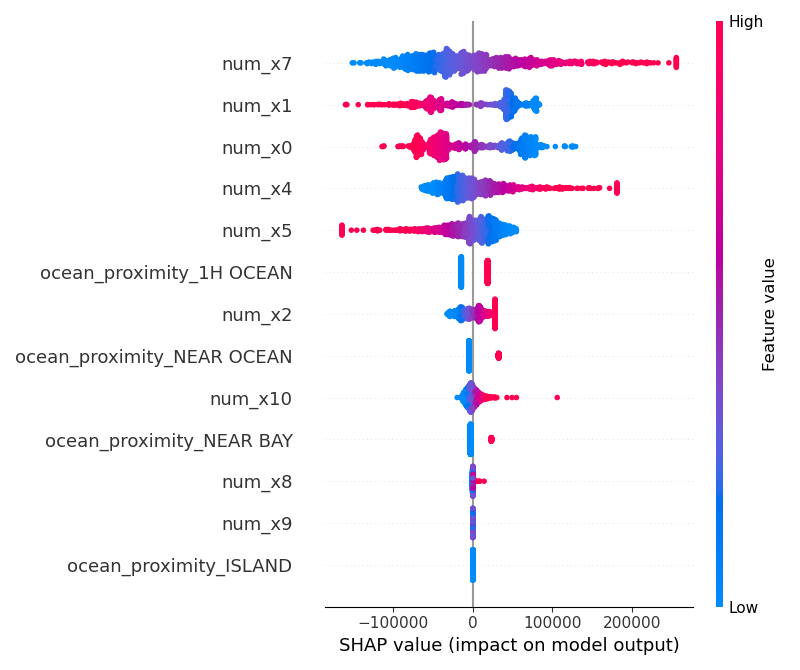

In [219]:
out = eda.get_feature_importances(train_X, train_y, y_continuous=True)
display_as_tabs([(k, v) for k,v in out.items()])

Key drivers report like feature importance, bivariate plots can be obtained as below

In [220]:
reports.key_drivers(train_X,train_y, './key_drivers_report.html', y_continuous=True)

**Dev Notes**
<details>
    
- The SHAP plots and bivariate plots in key drivers reports can be obtained by including quick=False as a parameter to key_drivers function call. 
- SHAP plots and bivariate plots often take long depending on data shape.
- The plot with shap is present [here](https://drive.google.com/file/d/1JOTMBLiv3LEqZ-kxZz0RokW9v5UyiGva/view?usp=sharing)

</details>


All the plots like feature analysis, interaction, key drivers can be obtained as a single plot using data exploration method as shown below. The output from this is available [here](https://drive.google.com/file/d/1209MzmSSEhiTYuPfHpaVXFXUVbkaJm0B/view?usp=sharing)

In [221]:
reports.data_exploration(train_X,train_y,'./data_exploration_report.html', y_continuous=True)

p-value may not be accurate for N > 5000.


In [228]:
# saving the list of relevant columns
save_pipeline(curated_columns, op.abspath(op.join(artifacts_folder, 'curated_columns.joblib')))

# save the feature pipeline
save_pipeline(features_transformer, op.abspath(op.join(artifacts_folder, 'features.joblib')))

# 4 Modelling

## 4.1 Modelling - Linear Regression

### 4.1.1 Feature Selection(Specific to Regression)

- Selecting Features specific to regression
- VIF : measure of the amount of multi-collinearity in a set of multiple regressor variables. 
- On a case to case basis VIF thresholds change. Generally 5 or 10 are acceptable levels.
- Usually on a recursive basis when removing the most collinear variable, there can be shuffle in VIF. 
- Often this section will not be part of the production code.

In [229]:
cols = list(train_X.columns)
vif = eda.calc_vif(train_X)
while max(vif.VIF) > 15:
    #removing the largest variable from VIF
    cols.remove(vif[(vif.VIF==vif.VIF.max())].variables.tolist()[0])
    vif = eda.calc_vif(train_X[cols])

In [230]:
reg_vars = vif.query('VIF < 15').variables
reg_vars = list(reg_vars)

### 4.1.2 Data transformations

In [231]:
# Custom Transformations like these can be utilised
def _custom_data_transform(df, cols2keep=None):
    """Transformation to drop some columns in the data
    
    Parameters
    ----------
        df - pd.DataFrame
        cols2keep - columns to keep in the dataframe
    """
    cols2keep = cols2keep or []
    if len(cols2keep):
        return (df
                .select_columns(cols2keep))
    else:
        return df

### 4.1.3 Model training pipeline

- Here we focus on creating a collection of pipelines that can be used for training respective models.
- Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.1.4 Model Pipeline Build

- This will be part of the production code (training only).

In [232]:
reg_ppln_ols = Pipeline([
    ('',FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('estimator', SKLStatsmodelOLS())
])
reg_ppln_ols.fit(train_X, train_y.values.ravel())


Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa1fb6a3280>,
                                     kw_args={'cols2keep': ['ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'num_x9', 'num_x2',
                                                            'num_x0', 'num_x10',
                                                            'num_x8', 'num_x5',
                                                            'ocean_proximity_1H '
                                                            'OCEAN',
                                                            'num_x4', 'num_x1',
                                                            'num_x7',
                                                            'ocean_proximity_ISLAND',
                                                            'ocean_proximity_NEAR '
                                                            'BAY']})),
                ('estimator', SKLStatsmodelOLS())])

In [233]:
reg_ppln_ols['estimator'].summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                      y   R-squared:                       0.666
Model:                            OLS   Adj. R-squared:                  0.666
Method:                 Least Squares   F-statistic:                     2533.
Date:                Sun, 29 Oct 2023   Prob (F-statistic):               0.00
Time:                        00:45:57   Log-Likelihood:            -2.0684e+05
No. Observations:               16512   AIC:                         4.137e+05
Df Residuals:                   16498   BIC:                         4.138e+05
Df Model:                          13                                         
Covariance Type:            nonrobust                                         
==============================================================================================
                                 coef    std err          t      P>|t|      [0.025      0.975]
----------------------------------------------------------------------------------------------
intercept                   1.826e+05   1385.740    131.804      0.000     1.8e+05    1.85e+05
ocean_proximity_NEAR OCEAN  4.044e+04   2452.659     16.487      0.000    3.56e+04    4.52e+04
num_x9                       415.6674    533.452      0.779      0.436    -629.956    1461.291
num_x2                        1.5e+04    604.861     24.794      0.000    1.38e+04    1.62e+04
num_x0                     -5.539e+04   2264.180    -24.465      0.000   -5.98e+04    -5.1e+04
num_x10                     9521.3063    672.106     14.166      0.000    8203.907    1.08e+04
num_x8                       939.9597    598.924      1.569      0.117    -233.996    2113.915
num_x5                     -4.281e+04   1153.031    -37.131      0.000   -4.51e+04   -4.06e+04
ocean_proximity_1H OCEAN    3.566e+04   1897.540     18.793      0.000    3.19e+04    3.94e+04
num_x4                      4.839e+04   1149.893     42.085      0.000    4.61e+04    5.06e+04
num_x1                     -5.577e+04   2391.321    -23.322      0.000   -6.05e+04   -5.11e+04
num_x7                      7.863e+04    706.170    111.350      0.000    7.72e+04       8e+04
ocean_proximity_ISLAND      1.599e+05   3.35e+04      4.778      0.000    9.43e+04    2.25e+05
ocean_proximity_NEAR BAY     2.94e+04   2544.314     11.554      0.000    2.44e+04    3.44e+04
==============================================================================
Omnibus:                     3527.617   Durbin-Watson:                   2.006
Prob(Omnibus):                  0.000   Jarque-Bera (JB):            13142.983
Skew:                           1.037   Prob(JB):                         0.00
Kurtosis:                       6.848   Cond. No.                         97.0
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

### 4.1.5 Model Evaluation(Linear Model)

This will be part of the production code.

In [234]:
reg_ppln = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':reg_vars})),
    ('Linear Regression', SKLStatsmodelOLS())
])

test_X = get_dataframe(
    features_transformer.transform(test_X), 
    get_feature_names_from_column_transformer(features_transformer)
)
#test_X = test_X[curated_columns]

In [235]:
reg_linear_report = RegressionReport(model=reg_ppln, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y, refit=True)
reg_linear_report.get_report(include_shap=False, file_path='regression_linear_model_report')

**Dev Notes**
Use SHAP for variable interpretability.
<details>

    1. Use SHAP=True to generate variable interpretability plots in the report
    2. SHAP is recommended for non parameteric models such as RF, xgboost.
    3. However, SHAP reports are time consuming depending on no.of records and model complexity.
    
A sample of regerssion report with SHAP can be found [here](https://drive.google.com/file/d/18RlQTsT1ze09Cgz-qpb4ha_cvyWbN5F5/view?usp=sharing).
</details>

### 4.1.6 Residual Analysis
- After scoring the model, it is recommended to do a residual analysis to know the distribution of errors
- we took a threshold of 30% above which it is marked as over prediction or underprediction
- This will not be part of the production code.

In [236]:
threshold=0.3
residual_analysis = test_X.copy()
residual_analysis['prediction'] = reg_ppln_ols.predict(test_X)
residual_analysis['actuals'] = test_y.reset_index(drop = True).iloc[:,0].values
residual_analysis['forecast_flag'] = 'good'
residual_analysis.loc[((residual_analysis['prediction'] > (1+threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'over predict'
residual_analysis.loc[((residual_analysis['prediction'] < (1-threshold) * residual_analysis['actuals'])\
                       & (residual_analysis['actuals']>100)),'forecast_flag'] = 'under predict'

In [239]:
residual_analysis.hvplot.kde(y="actuals",by="forecast_flag", ## Grouping by Predictions
                                width=800, height=400,
                                alpha=0.7,
                                ylabel="density",
                                xlabel="median_house_value",
                                title=f'median_house_value(density)',legend='top_right')

:NdOverlay   [forecast_flag]
   :Distribution   [actuals]   (Density)

- From the above plot we can infer that the higher "over predictions" are happening for unit_cost > 200.
- similarly, the higher "under predictions" are happening for unit_cost is zero.

This can help us tune the model by a separate model for unit_cost > 200


# 4.2 Modelling - XGBoost

## 4.2.1 Model training pipeline

Here we focus on creating a collection of pipelines that can be used for tranining respective models.

Each model pipeline will essentially be of the form
```
[
('preprocessing', preprocessing_pipeline),
('feature_selection', feature_selection_pipeline),
('estimator', estimator),
]
```

### 4.2.2 Model Pipeline Build

In [240]:
# let's find features for some decent defaults
estimator = XGBRegressor()
xgb_training_pipe_init = Pipeline([
    ('XGBoost', XGBRegressor())
])
xgb_training_pipe_init.fit(train_X, train_y)

Pipeline(steps=[('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode=1,
                              colsample_bytree=1, enable_categorical=False,
                              gamma=0, gpu_id=-1, importance_type=None,
                              interaction_constraints='',
                              learning_rate=0.300000012, max_delta_step=0,
                              max_depth=6, min_child_weight=1, missing=nan,
                              monotone_constraints='()', n_estimators=100,
                              n_jobs=8, num_parallel_tree=1, predictor='auto',
                              random_state=0, reg_alpha=0, reg_lambda=1,
                              scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

### 4.2.3 Model Tuning

<AxesSubplot:>

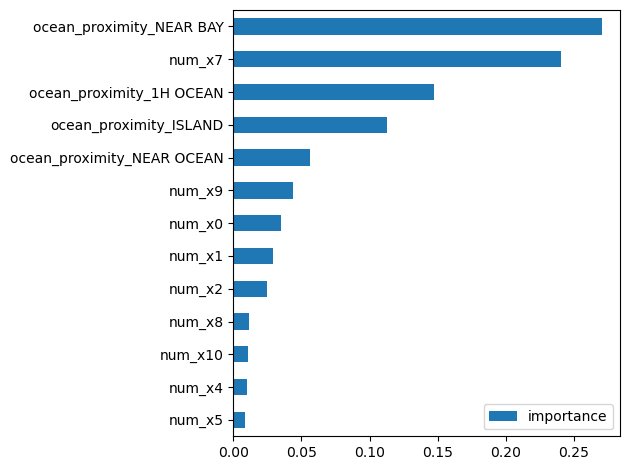

In [241]:
# Understanding the Feature Importance
%matplotlib inline
imp = pd.DataFrame({'importance': xgb_training_pipe_init['XGBoost'].feature_importances_})
imp.index = train_X.columns
imp.sort_values('importance',inplace=True)
imp.plot(kind='barh')

'condition','model_family','days_since_last_purchase','first_time_customer','sales_person', are considered to be important and in grid search

##### Pipeline build based on new importance features

In [242]:
test_X.columns

Index(['num_x0', 'num_x1', 'num_x2', 'num_x3', 'num_x4', 'num_x5', 'num_x6',
       'num_x7', 'num_x8', 'num_x9', 'num_x10', 'ocean_proximity_1H OCEAN',
       'ocean_proximity_INLAND', 'ocean_proximity_ISLAND',
       'ocean_proximity_NEAR BAY', 'ocean_proximity_NEAR OCEAN'],
      dtype='object')

In [244]:
#let's find features for some decent defaults
imp_features = ['ocean_proximity_NEAR BAY','num_x7','ocean_proximity_1H OCEAN','ocean_proximity_ISLAND','ocean_proximity_NEAR OCEAN','num_x9','num_x0']

estimator = XGBRegressor()
xgb_training_pipe2 = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', XGBRegressor())
])

#### Grid Search of the Estimator

In [245]:
%%time
parameters = {
   'gamma':[0.03],
   'min_child_weight':[6],
   'learning_rate':[0.1],
   'max_depth':[3],
   'n_estimators':[500], 
}
est = XGBRegressor()
xgb_grid = GridSearchCV(est,
                        parameters,
                        cv = 2,
                        n_jobs = 4,
                        verbose=True)

xgb_grid.fit(train_X, train_y)

print(xgb_grid.best_score_)
print(xgb_grid.best_params_)

Fitting 2 folds for each of 1 candidates, totalling 2 fits


/home/eswar_javvaji/miniconda3/envs/regression-codetmp-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/eswar_javvaji/miniconda3/envs/regression-codetmp-dev/lib/python3.9/site-packages/xgboost/compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index
/home/eswar_javvaji/miniconda3/envs/regression-codetmp-dev/lib/python3.9/site-packages/xgboost/data.py:262: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
/home/eswar_javvaji/miniconda3/envs/regression-codetmp-dev/lib

0.8236674426649087
{'gamma': 0.03, 'learning_rate': 0.1, 'max_depth': 3, 'min_child_weight': 6, 'n_estimators': 500}
CPU times: user 15.3 s, sys: 4.91 ms, total: 15.3 s
Wall time: 9.39 s


#### Pipeline Build using the best estimator

In [246]:
xgb_pipeline_final = Pipeline([
    ('', FunctionTransformer(_custom_data_transform, kw_args={'cols2keep':imp_features})),
    ('XGBoost', xgb_grid.best_estimator_)
])
xgb_pipeline_final.fit(train_X, train_y)

Pipeline(steps=[('',
                 FunctionTransformer(func=<function _custom_data_transform at 0x7fa1fb6a3280>,
                                     kw_args={'cols2keep': ['ocean_proximity_NEAR '
                                                            'BAY',
                                                            'num_x7',
                                                            'ocean_proximity_1H '
                                                            'OCEAN',
                                                            'ocean_proximity_ISLAND',
                                                            'ocean_proximity_NEAR '
                                                            'OCEAN',
                                                            'num_x9',
                                                            'num_x0']})),
                ('XGBoost',
                 XGBRegressor(base_score=0.5, booster='gbtree',
                              colsample_bylevel=1, colsample_bynode...
                              gamma=0.03, gpu_id=-1, importance_type=None,
                              interaction_constraints='', learning_rate=0.1,
                              max_delta_step=0, max_depth=3, min_child_weight=6,
                              missing=nan, monotone_constraints='()',
                              n_estimators=500, n_jobs=8, num_parallel_tree=1,
                              predictor='auto', random_state=0, reg_alpha=0,
                              reg_lambda=1, scale_pos_weight=1, subsample=1,
                              tree_method='exact', validate_parameters=1,
                              verbosity=None))])

In [247]:
reg_tree_report = RegressionReport(model=xgb_pipeline_final, x_train=train_X, y_train=train_y, x_test= test_X, y_test= test_y)
reg_tree_report.get_report(include_shap=False, file_path='regression_tree_model_report')

The Regression report containing the feature importances are available [here](https://drive.google.com/file/d/1JBfL3uxPcxBfl0amweXBFmLr7CSHFBUO/view?usp=sharing)

# 5 Model Comparison

Now, a comparison report of the  linear (vs) tree -based model  approach can be generated as follows.

This code will not be part of the production code.

In [254]:
model_pipelines = [reg_ppln, xgb_pipeline_final]
model_comparison_report = RegressionComparison(models=model_pipelines,x=train_X, y=train_y)
metrics = model_comparison_report.get_report(file_path='regression_comparison')

ValueError: Shape of passed values is (16512, 1), indices imply (16512, 13)

In [255]:
model_comparison_report.performance_metrics

metric,MAPE,WMAPE,MAE,RMSE,R^2
", Linear Regression",0.2841,0.2341,48438.2657,66675.8657,0.6662
", XGBoost",0.1929,0.1677,34705.6611,50809.1798,0.8062


A report comparing the performance, metrics between Linear model and Tree model are available [here](https://drive.google.com/file/d/1LDibiFap9K4DKME-Y0S0mtI_05lTdaJF/view?usp=sharing)

**Dev NOTES**
<details>

the above metrics are absolute nos and not %ges

In this example we are choosing LM model for pipelining. General criteria for choosing production models is:

- Parametric models (aka whitebox models) such as Linear Regression are easier to explain to non-technical audience.
- Generally these are accepted fast and adoption is quicker.
- If the downstream calls for optimization using these models parametric models are easier to implement.
- When accuracy is primary goal without explainability, the above two takes a backseat